In [1]:
pip install jcopml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.1 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32195 sha256=d9b5b3e5f99bc446e35654a019dd002ac8e47772e10ddd3716c135788671af3c
  Stored in directory: /root/.cache/pip/wheels/ea/b3/7d/0a33c9f0e642e714df1e619df91370950750a14afea5705565
Successfully built jcopml


# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

# Import Library

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [7]:
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1", error_bad_lines=False)
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 33319: expected 14 fields, saw 25\n'


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1.0,0.0,0.0,5.52,0.0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0.0,0.0,0.0,5.52,0.0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1.0,1.0,0.0,5.52,0.0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0.0,0.0,1.0,5.52,0.0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1.0,0.0,1.0,5.52,0.0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66924 entries, 0 to 66923
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         66924 non-null  int64  
 1   sales_channel          66924 non-null  object 
 2   trip_type              66924 non-null  object 
 3   purchase_lead          66924 non-null  int64  
 4   length_of_stay         66924 non-null  int64  
 5   flight_hour            66924 non-null  int64  
 6   flight_day             66924 non-null  object 
 7   route                  66924 non-null  object 
 8   booking_origin         66923 non-null  object 
 9   wants_extra_baggage    66922 non-null  float64
 10  wants_preferred_seat   66922 non-null  float64
 11  wants_in_flight_meals  66922 non-null  float64
 12  flight_duration        66922 non-null  float64
 13  booking_complete       66922 non-null  float64
dtypes: float64(5), int64(4), object(5)
memory usage: 7.1+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [9]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri', '8.58'],
      dtype=object)

In [10]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [11]:
df["flight_day"].unique()

array([ 6.,  3.,  4.,  1.,  7.,  2.,  5., nan])

In [12]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day               float64
route                     object
booking_origin            object
wants_extra_baggage      float64
wants_preferred_seat     float64
wants_in_flight_meals    float64
flight_duration          float64
booking_complete         float64
dtype: object

In [13]:
df.booking_complete.value_counts(normalize=True)

0.0    0.837677
1.0    0.162323
Name: booking_complete, dtype: float64

#### target kita imbalance, kita coba predict tanpa resample dan pakai resample

In [14]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,66924.00000,66924.000000,66924.000000,66924.000000,66923.000000,66922.000000,66922.000000,66922.000000,66922.000000,66922.000000
mean,1.65038,86.821051,18.567659,9.121914,3.816177,0.648098,0.294417,0.412988,7.168343,0.162323
std,1.07740,92.614499,30.285510,5.393958,1.996622,0.477567,0.455784,0.492374,1.490851,0.368750
min,1.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.00000,21.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.00000,52.000000,6.000000,9.000000,4.000000,1.000000,0.000000,0.000000,7.000000,0.000000
75%,2.00000,118.000000,23.000000,13.000000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.00000,867.000000,778.000000,23.000000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [15]:
df.shape

(66924, 14)

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [16]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               1
route                    0
booking_origin           1
wants_extra_baggage      2
wants_preferred_seat     2
wants_in_flight_meals    2
flight_duration          2
booking_complete         2
dtype: int64

In [18]:
df.dropna(inplace=True)

In [19]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [20]:
df.shape

(66922, 14)

# EDA (Exploratory Data Analysis)

### Sales Channel

In [21]:
df.sales_channel.value_counts()

Internet    58844
Mobile       8078
Name: sales_channel, dtype: int64

In [22]:
sales_internet = df.sales_channel.value_counts().values[0]  / df.sales_channel.count() *100
sales_mobile = df.sales_channel.value_counts().values[1]  / df.sales_channel.count() *100

print("Internet sales: {:.2f}%".format(sales_internet))
print("Mobile sales: {:.2f}%".format(sales_mobile))

Internet sales: 87.93%
Mobile sales: 12.07%


<AxesSubplot:xlabel='sales_channel', ylabel='count'>

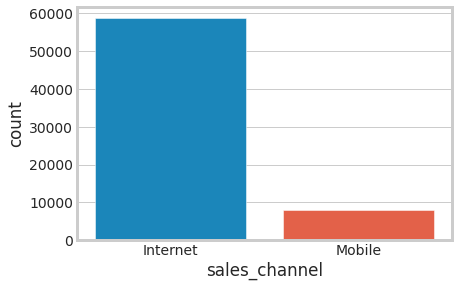

In [23]:
sns.countplot(x="sales_channel", data=df)

### Trip Type

In [24]:
df.trip_type.value_counts()

RoundTrip     66315
OneWay          455
CircleTrip      152
Name: trip_type, dtype: int64

In [25]:
trip_round = df.trip_type.value_counts().values[0]  / df.trip_type.count() *100
trip_oneway = df.trip_type.value_counts().values[1]  / df.trip_type.count() *100
trip_circle = df.trip_type.value_counts().values[2]  / df.trip_type.count() *100

print("Round trip: {:.2f}%".format(trip_round))
print("Oneway trip: {:.2f}%".format(trip_oneway))
print("Circle trip: {:.2f}%".format(trip_circle))

Round trip: 99.09%
Oneway trip: 0.68%
Circle trip: 0.23%


<AxesSubplot:xlabel='trip_type', ylabel='count'>

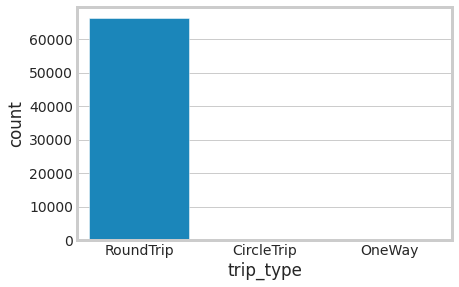

In [26]:
sns.countplot(x="trip_type", data=df)

### Puchase Lead

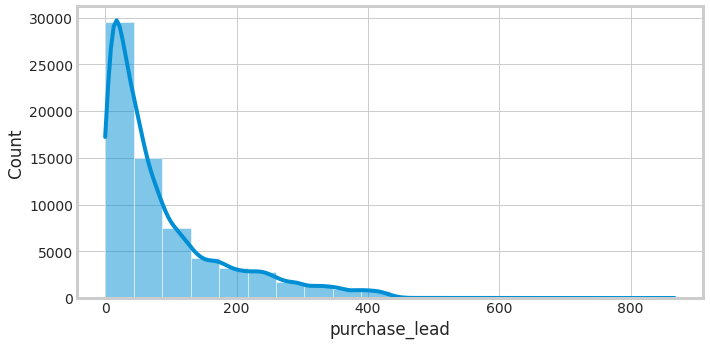

In [27]:
# distribution data puchase_lead
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="purchase_lead", kde=True, bins=20)
plt.show()

#### ada pemesanan yang dilakukan lebih dari 2 tahun sebelum tanggal perjalanan dan tampak nya sangat tidak mungkin. kita anggap saja outlier

In [28]:
(df.purchase_lead > 600).value_counts()

False    66909
True        13
Name: purchase_lead, dtype: int64

In [29]:
df[df.purchase_lead > 600]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
835,3,Internet,RoundTrip,641,46,6,7.0,AKLKUL,Malaysia,1.0,0.0,1.0,8.83,1.0
6148,1,Internet,RoundTrip,614,19,11,3.0,COKMEL,Australia,0.0,0.0,0.0,8.83,0.0
21674,2,Internet,RoundTrip,633,5,10,6.0,HKTOOL,Australia,0.0,0.0,1.0,8.83,0.0
22735,1,Mobile,RoundTrip,625,5,15,5.0,ICNRGN,Myanmar (Burma),0.0,0.0,0.0,6.62,0.0
26234,1,Mobile,RoundTrip,605,6,18,4.0,BLRMEL,India,0.0,0.0,0.0,8.83,0.0
30034,2,Internet,RoundTrip,606,6,6,5.0,HKTTPE,United States,0.0,0.0,1.0,4.67,0.0
31577,3,Internet,RoundTrip,867,6,7,1.0,KIXMLE,Japan,0.0,0.0,1.0,7.00,1.0
41054,1,Internet,RoundTrip,704,23,8,2.0,PNHSYD,Australia,0.0,0.0,0.0,8.58,0.0
55291,2,Internet,RoundTrip,633,5,10,6.0,HKTOOL,Australia,0.0,0.0,1.0,8.83,0.0
56352,1,Mobile,RoundTrip,625,5,15,5.0,ICNRGN,Myanmar (Burma),0.0,0.0,0.0,6.62,0.0


#### jika kita asumsikan tidak ada pelanggan yang memesan lebih awal dari 1 setengah tahun, maka kita akan hapus data yang lebih dari 600 hari

In [30]:
df = df[df.purchase_lead < 600]
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6.0,AKLDEL,New Zealand,1.0,0.0,0.0,5.52,0.0
1,1,Internet,RoundTrip,112,20,3,6.0,AKLDEL,New Zealand,0.0,0.0,0.0,5.52,0.0
2,2,Internet,RoundTrip,243,22,17,3.0,AKLDEL,India,1.0,1.0,0.0,5.52,0.0
3,1,Internet,RoundTrip,96,31,4,6.0,AKLDEL,New Zealand,0.0,0.0,1.0,5.52,0.0
4,2,Internet,RoundTrip,68,22,15,3.0,AKLDEL,India,1.0,0.0,1.0,5.52,0.0


In [31]:
df.shape

(66909, 14)

###  Length of Stay

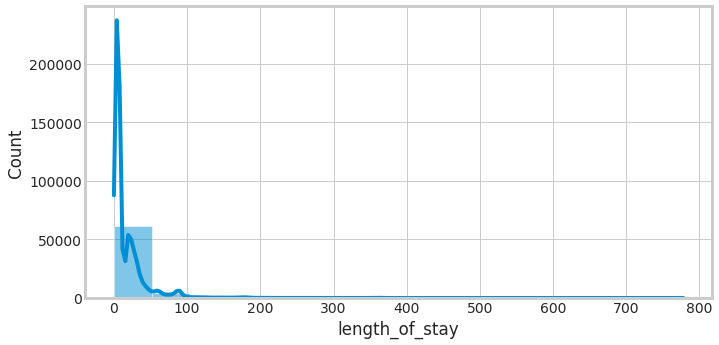

In [32]:
# distribution data length_of_stay
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="length_of_stay", kde=True, bins=15)
plt.show()

#### maari kita cek berapa banyak data yang melebihi lama tinggal lebih 200 hari

In [33]:
(df.length_of_stay > 200).value_counts()

False    66630
True       279
Name: length_of_stay, dtype: int64

In [34]:
df[df.length_of_stay > 500].booking_complete.value_counts()

0.0    9
1.0    1
Name: booking_complete, dtype: int64

#### Kita perlu memiliki lebih banyak pengetahuan bisnis untuk memutuskan apakah akan menghapus entri ini dengan masa inap lebih dari 600 hari. Mungkin ada banyak alasan untuk pemesanan tersebut. Namun untuk saat ini, kami hanya ingin fokus pada pemesanan yang dilakukan untuk lama tinggal kurang dari 500 hari.

In [35]:
df = df[df.length_of_stay < 500]
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6.0,AKLDEL,New Zealand,1.0,0.0,0.0,5.52,0.0
1,1,Internet,RoundTrip,112,20,3,6.0,AKLDEL,New Zealand,0.0,0.0,0.0,5.52,0.0
2,2,Internet,RoundTrip,243,22,17,3.0,AKLDEL,India,1.0,1.0,0.0,5.52,0.0
3,1,Internet,RoundTrip,96,31,4,6.0,AKLDEL,New Zealand,0.0,0.0,1.0,5.52,0.0
4,2,Internet,RoundTrip,68,22,15,3.0,AKLDEL,India,1.0,0.0,1.0,5.52,0.0


In [36]:
df.shape

(66899, 14)

### Booking Origin

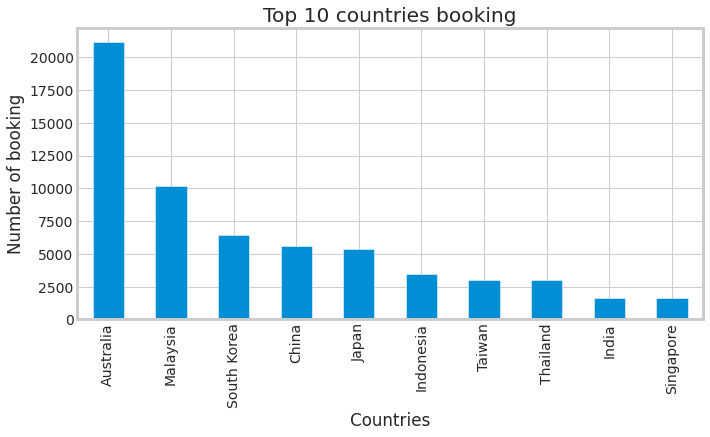

In [37]:
plt.figure(figsize=(10, 5))
ax = df.booking_origin.value_counts()[:10].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of booking")
ax.set_title("Top 10 countries booking")
plt.show()

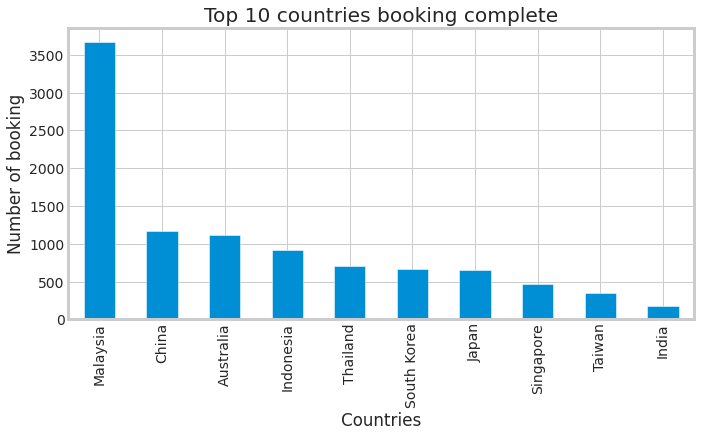

In [38]:
plt.figure(figsize=(10, 5))
ax = df[df.booking_complete == 1].booking_origin.value_counts()[:10].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of booking")
ax.set_title("Top 10 countries booking complete")
plt.show()

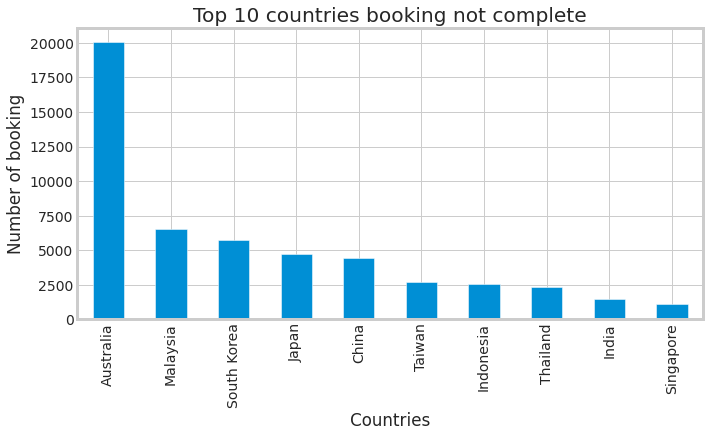

In [39]:
plt.figure(figsize=(10, 5))
ax = df[df.booking_complete == 0].booking_origin.value_counts()[:10].plot(kind="bar")
ax.set_xlabel("Countries")
ax.set_ylabel("Number of booking")
ax.set_title("Top 10 countries booking not complete")
plt.show()

In [40]:
print('percentage booking success: {:.2f}%'.format((df.booking_complete == 1).sum() / df.booking_complete.count() * 100))
print('percentage booking failure: {:.2f}%'.format((df.booking_complete == 0).sum() / df.booking_complete.count() * 100))

percentage booking success: 16.23%
percentage booking failure: 83.77%


### Correlation

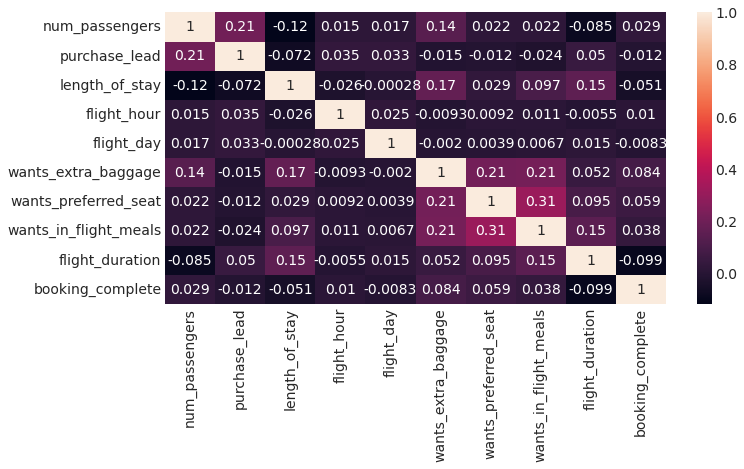

In [41]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [42]:
# Drop column yang tidak penting
df.drop(['route'], axis=1, inplace=True)

# Dataset Spliting

In [43]:
X = df.drop(columns="booking_complete")
y = df.booking_complete

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53519, 12), (13380, 12), (53519,), (13380,))

# Training

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from jcopml.tuning import random_search_params as rsp

In [50]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [46]:
X_train.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
18554,2,Internet,RoundTrip,51,5,14,7.0,South Korea,1.0,0.0,0.0,6.62
17302,1,Mobile,RoundTrip,0,4,14,6.0,Australia,0.0,0.0,0.0,5.62
4499,1,Internet,RoundTrip,18,40,6,2.0,China,1.0,0.0,1.0,4.83
27172,9,Mobile,RoundTrip,362,6,19,6.0,Thailand,0.0,0.0,0.0,8.67
15499,1,Internet,RoundTrip,27,69,1,4.0,Malaysia,1.0,0.0,0.0,4.75


In [ ]:
X_train.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'booking_origin',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration'],
      dtype='object')

In [51]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ["num_passengers", "purchase_lead", "length_of_stay", "flight_hour", "flight_day", "flight_duration"]),
    ('categoric', cat_pipe(encoder='onehot'), ["sales_channel", "trip_type", "booking_origin", 'wants_extra_baggage', 
                                               'wants_preferred_seat', 'wants_in_flight_meals']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6439756413500356, 'algo__gamma': 4, 'algo__learning_rate': 0.7686119654652775, 'algo__max_depth': 7, 'algo__n_estimators': 158, 'algo__reg_alpha': 0.601367193359287, 'algo__reg_lambda': 3.325610295975196, 'algo__subsample': 0.6121770240668967}
0.5115402021421029 0.32802407665895666 0.345800122624157


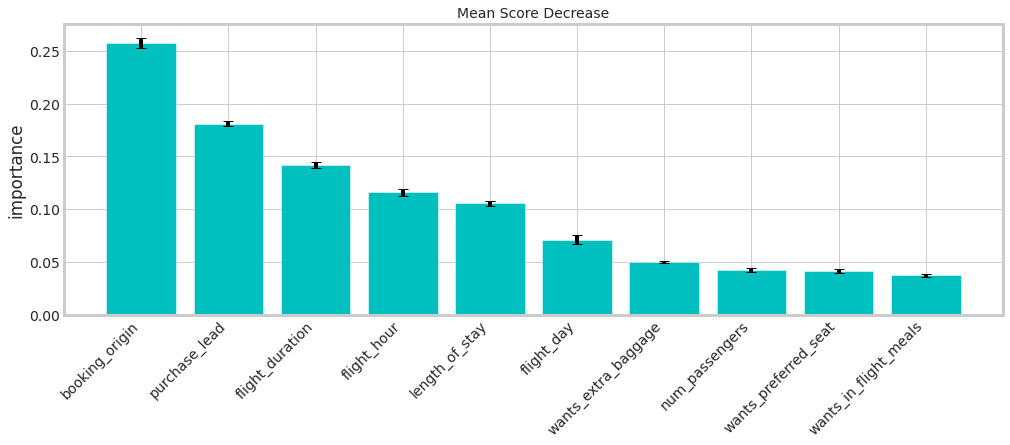

In [52]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [78]:
from jcopml.plot import plot_classification_report, plot_roc_curve, plot_confusion_matrix

In [54]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     44832
         1.0       0.74      0.39      0.51      8687

    accuracy                           0.88     53519
   macro avg       0.82      0.68      0.72     53519
weighted avg       0.87      0.88      0.86     53519


Test report
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     11208
         1.0       0.52      0.26      0.35      2172

    accuracy                           0.84     13380
   macro avg       0.69      0.61      0.63     13380
weighted avg       0.81      0.84      0.82     13380



# Resample Target

In [70]:
X = df.drop(columns="booking_complete")
y = df.booking_complete

In [69]:
X_train

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
18554,2,Internet,RoundTrip,51,5,14,7.0,South Korea,1.0,0.0,0.0,6.62
17302,1,Mobile,RoundTrip,0,4,14,6.0,Australia,0.0,0.0,0.0,5.62
4499,1,Internet,RoundTrip,18,40,6,2.0,China,1.0,0.0,1.0,4.83
27172,9,Mobile,RoundTrip,362,6,19,6.0,Thailand,0.0,0.0,0.0,8.67
15499,1,Internet,RoundTrip,27,69,1,4.0,Malaysia,1.0,0.0,0.0,4.75
...,...,...,...,...,...,...,...,...,...,...,...,...
6440,1,Internet,RoundTrip,20,84,12,3.0,Australia,1.0,1.0,1.0,8.83
11385,1,Internet,RoundTrip,57,85,14,7.0,China,1.0,0.0,1.0,8.83
24362,3,Internet,RoundTrip,288,5,6,5.0,Malaysia,0.0,1.0,0.0,8.83
7130,1,Internet,RoundTrip,161,26,13,3.0,Australia,1.0,1.0,1.0,8.58


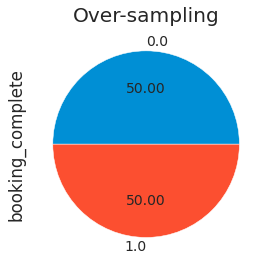

In [71]:
from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_res, y_res = ros.fit_resample(X, y)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [72]:
y_res.value_counts()

0.0    56040
1.0    56040
Name: booking_complete, dtype: int64

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89664, 12), (22416, 12), (89664,), (22416,))

In [75]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ["num_passengers", "purchase_lead", "length_of_stay", "flight_hour", "flight_day", "flight_duration"]),
    ('categoric', cat_pipe(encoder='onehot'), ["sales_channel", "trip_type", "booking_origin", 'wants_extra_baggage', 
                                               'wants_preferred_seat', 'wants_in_flight_meals']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='f1', n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6439756413500356, 'algo__gamma': 4, 'algo__learning_rate': 0.7686119654652775, 'algo__max_depth': 7, 'algo__n_estimators': 158, 'algo__reg_alpha': 0.601367193359287, 'algo__reg_lambda': 3.325610295975196, 'algo__subsample': 0.6121770240668967}
0.8829848103725616 0.816155987613883 0.8422178488919313


In [77]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.87     44832
         1.0       0.86      0.91      0.88     44832

    accuracy                           0.88     89664
   macro avg       0.88      0.88      0.88     89664
weighted avg       0.88      0.88      0.88     89664


Test report
              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83     11208
         1.0       0.81      0.88      0.84     11208

    accuracy                           0.84     22416
   macro avg       0.84      0.84      0.84     22416
weighted avg       0.84      0.84      0.84     22416



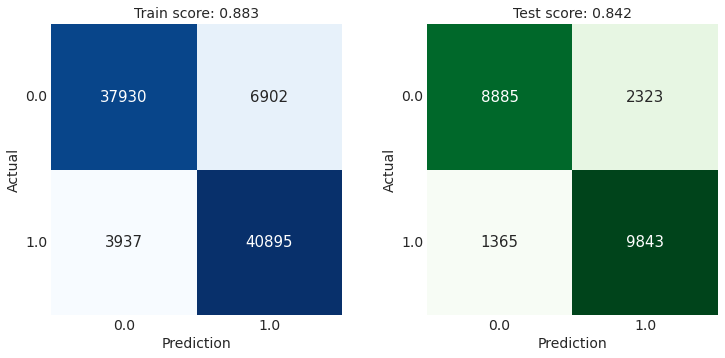

In [79]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

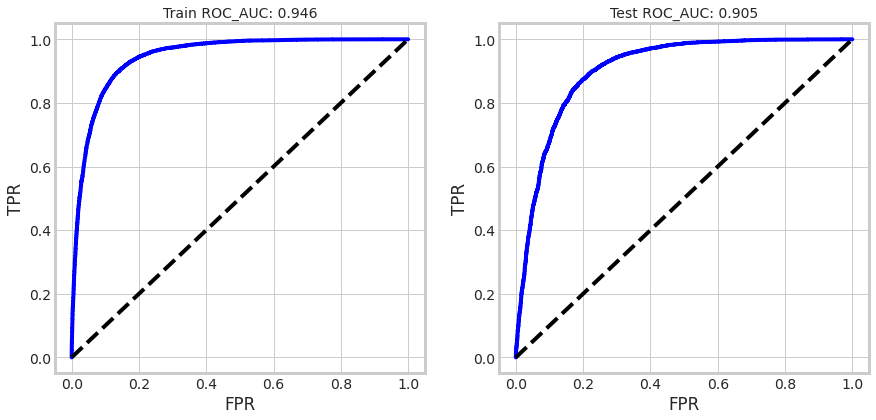

In [80]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

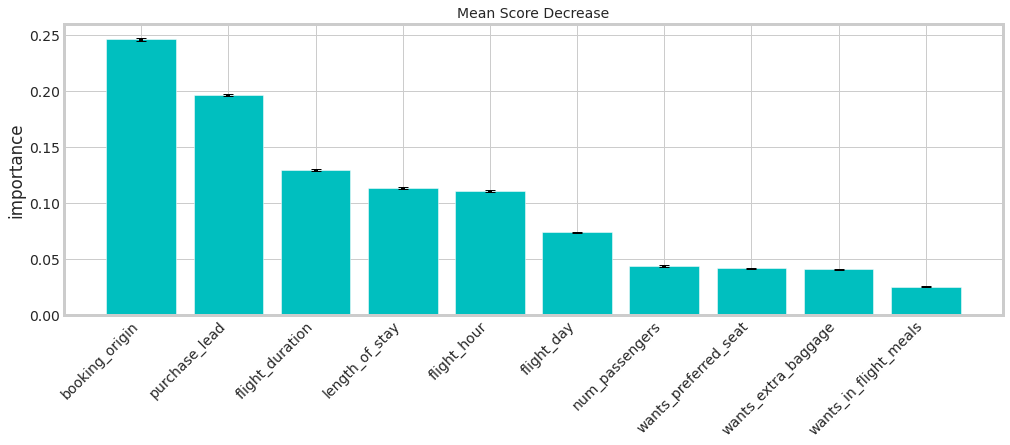

In [82]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)